In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Input, GRU, Dense,Flatten,Dropout,Conv1D, MaxPooling1D
from keras.callbacks import EarlyStopping
from keras.losses import mean_squared_error
import mlflow.tensorflow
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
def create_sequences(dataset, timesteps=1, dropNa=True):
    """Converts time series into a data set for supervised machine learning models"""
    # drop row's which include Nan elements (data preprocessing)
    df = pd.DataFrame(dataset)
    if dropNa:
        df.dropna(inplace=True)
    dataset = df.values
    # create x and y out of dataset
    dataX, dataY = [], []
    for i in range(len(dataset)):
        endIdx = i + timesteps
        # stop if reached the end of dataset
        if endIdx + 1 > len(dataset):
            break
        dataX.append(dataset[i:endIdx, :])
        dataY.append(dataset[endIdx, :])
    return np.array(dataX), np.array(dataY)

In [3]:
def test_train(datasetsize, testsize, shuffle=True):
    """Returns two dataset to train and test machine learning models"""
    if shuffle:
        ntest = int(np.ceil(testsize * datasetsize))
        idx = np.arange(0, datasetsize)
        np.random.shuffle(idx)
        train_index = idx[ntest:]
        test_index = idx[:ntest]
        return train_index, test_index
    else:
        #TODO: Check datasplitting use int(np.ceil(testsize * datasetsize))
        ntest = int(np.ceil(testsize * datasetsize))
        idx = np.arange(0, datasetsize)
        test_index = idx[datasetsize - ntest:]
        train_index = idx[:datasetsize - ntest]
        return train_index, test_index

In [4]:
def LSTM_model():
    model = ks.Sequential()
    model.add(ks.layers.LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(ks.layers.LSTM(units=50, return_sequences=False))
    model.add(ks.layers.Dense(units=25))
    model.add(ks.layers.Dense(units=1))
    model.compile(optimizer='adam',
              loss=mean_squared_error,
              metrics=['accuracy'])
    return model

In [293]:
def build_model_cnn(n_steps,n_feats,n_fore=1):
    model = Sequential()
    model.add(Conv1D(filters=50, kernel_size=3, activation='relu',input_shape=(n_steps,n_feats)))
    #model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(Flatten())
    #model.add(Dropout(0.20))
    #model.add(Dense(128, activation='relu'))
    #model.add(Dense(32, activation='relu'))
    model.add(Dense(n_fore, activation='linear'))
    model.compile(optimizer='adam',
                  loss=mean_squared_error,
                  metrics=['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'cosine_proximity']
                 )
    return model

In [322]:
# Create a test Sequence
seq = pd.DataFrame([[1,101],[2,102],[3,103],[4,104],[5,105],[6,106],[7,107],[8,108],[9,109],[10,110]])
n_steps = 5
dropNan = False
shuffle = True

In [323]:
X_Data, y_Data = create_sequences(seq, n_steps, dropNan)

In [324]:
train_index, test_index = test_train(len(X_Data), 0.33, shuffle)
print(train_index,test_index)

[4 0 1] [2 3]


In [325]:
# rename the columns of y_Data
X_train = X_Data[train_index]
X_test = X_Data[test_index]
y_train = y_Data[train_index]
y_test = y_Data[test_index]

In [326]:
n_feats = X_train.shape[2]
n_fore = seq.shape[1]
print(n_steps,n_feats,n_fore)

5 2 2


In [327]:
model = build_model_cnn(n_steps,n_feats,n_fore)
model.summary()

history = model.fit(
    X_train,
    y_train,
    batch_size=10,
    epochs=100,
    validation_data=(X_test, y_test),
    callbacks=[
        EarlyStopping(patience=10),
    ],
)

Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_62 (Conv1D)           (None, 3, 50)             350       
_________________________________________________________________
max_pooling1d_45 (MaxPooling (None, 1, 50)             0         
_________________________________________________________________
flatten_46 (Flatten)         (None, 50)                0         
_________________________________________________________________
dense_94 (Dense)             (None, 2)                 102       
Total params: 452
Trainable params: 452
Non-trainable params: 0
_________________________________________________________________
Train on 3 samples, validate on 2 samples
Epoch 1/100
3/3 [==============================] - 0s 47ms/step - loss: 5337.0610 - mean_squared_error: 5337.0610 - val_loss: 5123.0171 - val_mean_squared_error: 5123.0171
Epoch 2/100
3/3 [======================

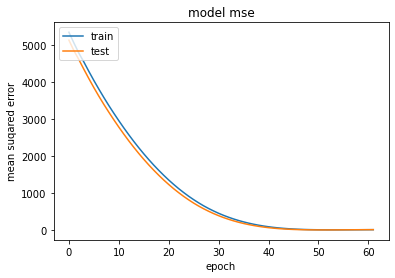

KeyError: 'mean_absolute_error'

<Figure size 432x288 with 0 Axes>

In [328]:
# summarize history for accuracy
plt.figure()
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('model mse')
plt.ylabel('mean suqared error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.figure()
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model mae')
plt.ylabel('mean absolute error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.figure()
plt.plot(history.history['mean_absolute_percentage_error'])
plt.plot(history.history['val_mean_absolute_percentage_error'])
plt.title('model mean absolute percentage error')
plt.ylabel('mean absolute percentage error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.figure()
plt.plot(history.history['cosine_proximity'])
plt.plot(history.history['val_cosine_proximity'])
plt.title('model cosine proximity')
plt.ylabel('cosine proximity')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [259]:
print(y_train[0])
model.predict(np.reshape(X_train[0], (1,X_train[0].shape[0], X_train[0].shape[1])))

[  6 106]


array([[  7.1593447, 106.127174 ]], dtype=float32)

In [316]:
predictions = model.predict(X_test)
print(predictions)

[[  7.391366  111.137596 ]
 [  7.6271095 113.205894 ]]


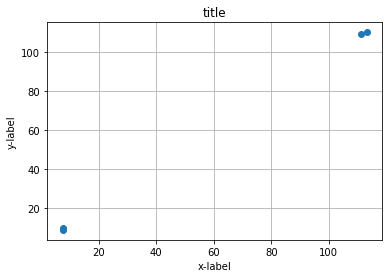

In [317]:
# Visualize the data
plt.figure()
plt.scatter(predictions,y_test)
plt.grid(True)
plt.title("title")
plt.xlabel("x-label")
plt.ylabel("y-label")
plt.show()

In [414]:
def build_model_cnn(n_steps,n_feats,n_fore=1):
    model = Sequential()
    model.add(Conv1D(filters=50, kernel_size=3, activation='relu',input_shape=(n_steps,n_feats)))
    #model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(Flatten())
    #model.add(Dropout(0.20))
    #model.add(Dense(128, activation='relu'))
    #model.add(Dense(32, activation='relu'))
    model.add(Dense(n_fore, activation='linear'))
    model.compile(optimizer='adam',
                  loss=mean_squared_error,
                  metrics=['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'cosine_proximity']
                 )
    return model

In [415]:
dataset = pd.read_csv('../data/Forecast Data/dataset.csv')
dataset['DATE'] = [datetime.strptime(date, '%Y-%m-%d') for date in dataset['DATE']]
dataset = dataset.set_index('DATE')
dataset = dataset[:-3]

In [416]:
dataset.isnull().sum()
#TODO: Add COVID numbers
#TODO: Remove NaN values (April)

Alte Pinakothek                             0
Ausland (Tourismus)                         0
Olympiapark                                 0
Bayerisches Nationalmuseum                  0
Bayerisches Staatsorchester                 0
Deutsches Museum                            0
Inland (Tourismus)                          0
Kleine Olympiahalle                         0
Museum Brandhorst                           0
Museum Mensch und Natur                     0
Muenchner Kammerspiele                      0
Muenchner Philharmoniker                    0
Muenchner Stadtmuseum                       0
Nationaltheater                             0
Neue Pinakothek                             0
Olympia-Eissportzentrum                     0
Olympiahalle                                0
Olympiastadion                              0
Olympiaturm                                 0
Pinakothek der Moderne                      0
Prinzregententheater                        0
Residenztheater                   

In [417]:
n_steps = 5
dropNan = False
shuffle = True

In [418]:
X_Data, y_Data = create_sequences(dataset, n_steps, dropNan)

In [419]:
train_index, test_index = test_train(len(X_Data), 0.33, shuffle)

In [420]:
# rename the columns of y_Data
X_train = X_Data[train_index]
X_test = X_Data[test_index]
y_train = y_Data[train_index]
y_test = y_Data[test_index]

In [421]:
n_feats = X_train.shape[2]
n_fore = dataset.shape[1]
print(n_steps,n_feats,n_fore)

5 28 28


In [427]:
model = build_model_cnn(n_steps,n_feats,n_fore)
model.summary()

history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=100,
    validation_data=(X_test, y_test),
    callbacks=[
        EarlyStopping(patience=10),
    ],
)

Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_71 (Conv1D)           (None, 3, 50)             4250      
_________________________________________________________________
max_pooling1d_54 (MaxPooling (None, 1, 50)             0         
_________________________________________________________________
flatten_55 (Flatten)         (None, 50)                0         
_________________________________________________________________
dense_103 (Dense)            (None, 28)                1428      
Total params: 5,678
Trainable params: 5,678
Non-trainable params: 0
_________________________________________________________________
Train on 159 samples, validate on 79 samples
Epoch 1/100
159/159 [==============================] - 0s 2ms/step - loss: 0.0078 - mean_squared_error: 0.0078 - mean_absolute_error: 0.0543 - mean_absolute_percentage_error: 2209543.7500 - cosine_proximi

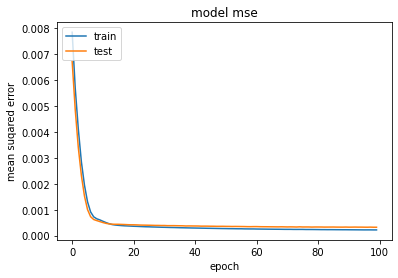

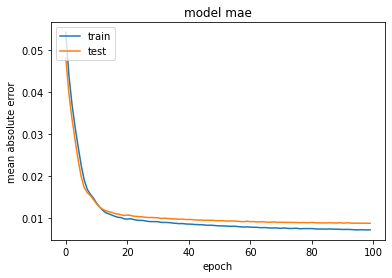

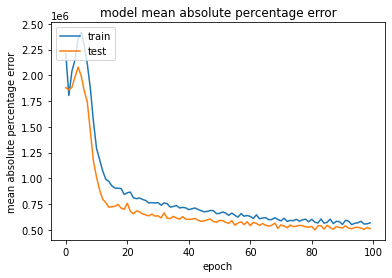

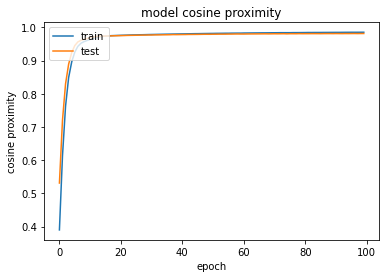

In [428]:
# summarize history for accuracy
plt.figure()
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('model mse')
plt.ylabel('mean suqared error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.figure()
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model mae')
plt.ylabel('mean absolute error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.figure()
plt.plot(history.history['mean_absolute_percentage_error'])
plt.plot(history.history['val_mean_absolute_percentage_error'])
plt.title('model mean absolute percentage error')
plt.ylabel('mean absolute percentage error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.figure()
plt.plot(history.history['cosine_proximity'])
plt.plot(history.history['val_cosine_proximity'])
plt.title('model cosine proximity')
plt.ylabel('cosine proximity')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [429]:
print(y_train[0])
model.predict(np.reshape(X_train[0], (1,X_train[0].shape[0], X_train[0].shape[1])))

[3.41693569e-03 1.58974427e-01 4.17808265e-03 2.87075242e-03
 1.86631810e-03 2.27027985e-02 2.10727760e-01 1.06933471e-03
 2.82249526e-03 4.84737651e-03 4.65813168e-03 5.01660558e-03
 4.28145168e-03 1.05334130e-02 4.65023506e-03 1.26592779e-02
 1.58530242e-02 8.59032219e-04 9.13815059e-03 7.55553522e-03
 5.46512295e-03 5.14594024e-03 2.82688228e-04 1.09036496e-03
 7.06720570e-03 5.19051366e-03 1.09634227e-02 4.76113604e-01]


array([[ 4.6268683e-03,  1.7548195e-01,  1.0239055e-02,  2.6307655e-03,
        -3.1659473e-03,  2.1153029e-02,  2.0775300e-01,  4.3873782e-03,
         4.8268670e-03,  5.0778231e-03,  5.0841542e-03,  5.1991176e-04,
         2.5587976e-03,  9.5276684e-03,  6.5129511e-03,  8.6552314e-03,
         2.1513307e-02,  5.4438896e-03,  1.3496201e-02, -1.0235794e-03,
         8.8952947e-03,  7.6508801e-03, -4.2855367e-04, -4.9001724e-04,
         8.6211693e-03,  5.8455691e-03,  1.6656568e-02,  4.6873254e-01]],
      dtype=float32)

In [430]:
predictions = model.predict(X_test)
print(predictions)

[[ 8.4069390e-03  1.6450371e-01  1.7509505e-02 ...  2.7068332e-04
   2.1467367e-02  4.5425031e-01]
 [ 1.1130369e-02  1.8293396e-01  2.2190463e-02 ... -1.0892078e-03
   2.0289049e-02  4.5037252e-01]
 [ 5.8739208e-02  1.6243170e-01  1.5750347e-02 ...  7.1133345e-02
   3.9423078e-02  3.7125906e-01]
 ...
 [ 5.2752513e-03  1.7543049e-01  8.6859418e-03 ...  9.1458634e-03
   1.3037469e-02  4.6919915e-01]
 [ 8.8199172e-03  1.7427003e-01  2.1291588e-02 ...  2.0774752e-03
   1.5394412e-02  4.5230058e-01]
 [ 1.0104513e-02  1.7271687e-01  2.3235627e-02 ... -5.6125969e-04
   2.5559559e-02  4.4201508e-01]]


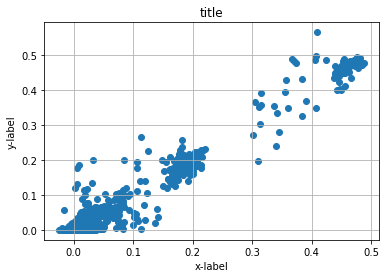

In [431]:
# Visualize the data
plt.figure()
plt.scatter(predictions,y_test)
plt.grid(True)
plt.title("title")
plt.xlabel("x-label")
plt.ylabel("y-label")
plt.show()